In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, SimpleRNN, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

In [24]:
# Load dataset
df = pd.read_csv("ercot_2019.csv")
# Remove rows where 'E' is 0.0
df = df[df['E'] != 0.0]
df.head()

,Unnamed: 0,DATETIME,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,E,I,D,H,Avg,Std,Avg_w,Std_w
0,0,2019-01-01 01:00:00,"9,783.59","1,264.19","3,164.72",827.76,"11,697.77","3,066.89","5,993.97","1,282.54",37081.44,2,1,0,0.0,0.0,0.000,0.000
1,1,2019-01-01 02:00:00,"9,726.06","1,270.49","3,178.95",830.26,"11,787.94","3,140.38","6,029.77","1,295.13",37258.99,4,1,0,0.0,0.0,37170.215,88.775
2,2,2019-01-01 03:00:00,"9,654.37","1,269.50","3,200.88",831.51,"11,861.63","3,137.72","6,043.35","1,301.23",37300.19,6,1,0,0.0,0.0,37279.590,20.600
3,3,2019-01-01 04:00:00,"9,631.74","1,243.17","3,221.96",839.69,"11,989.11","3,105.50","6,086.41","1,305.98",37423.54,8,1,0,0.0,0.0,37361.865,61.675
4,4,2019-01-01 05:00:00,"9,698.89","1,309.57","3,240.63",848.67,"12,219.11","3,078.26","6,180.94","1,319.14",37895.21,10,1,0,0.0,0.0,37659.375,235.835


In [25]:
# Preprocessing
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.set_index('DATETIME', inplace=True)
features = ['E']  # Only using electricity usage (kW) as the feature(X)
target = 'E'

In [26]:
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df[target] = scaler.fit_transform(df[[target]])

In [27]:
# Create sequences
def create_sequences(data, target, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data.iloc[i:i+timesteps].values)
        y.append(target.iloc[i+timesteps])
    return np.array(X), np.array(y)

In [28]:
# Define DeepDeFF models
def build_deepdeff(model_type, timesteps):
    input_layer = Input(shape=(timesteps, len(features)))
    if model_type == 'GRU':
        x = GRU(64, return_sequences=False)(input_layer)
    elif model_type == 'LSTM':
        x = LSTM(64, return_sequences=False)(input_layer)
    elif model_type == 'RNN':
        x = SimpleRNN(64, return_sequences=False)(input_layer)
    elif model_type == 'BGRU':
        x = Bidirectional(GRU(64, return_sequences=False))(input_layer)
    elif model_type == 'BLSTM':
        x = Bidirectional(LSTM(64, return_sequences=False))(input_layer)
    elif model_type == 'BRNN':
        x = Bidirectional(SimpleRNN(64, return_sequences=False))(input_layer)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model
    

In [29]:
# Define Traditional Models
def build_traditional_model(model_type, timesteps):
    model = Sequential()
    if model_type == 'GRU':
        model.add(GRU(64, return_sequences=False, input_shape=(timesteps, len(features))))
    elif model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, len(features))))
    elif model_type == 'RNN':
        model.add(SimpleRNN(64, return_sequences=False, input_shape=(timesteps, len(features))))
    elif model_type == 'BGRU':
        model.add(Bidirectional(GRU(64, return_sequences=False), input_shape=(timesteps, len(features))))
    elif model_type == 'BLSTM':
        model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(timesteps, len(features))))
    elif model_type == 'BRNN':
        model.add(Bidirectional(SimpleRNN(64, return_sequences=False), input_shape=(timesteps, len(features))))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [30]:
# Train and evaluate models
timesteps_list = [2, 6, 12]
models = ['BGRU', 'BLSTM', 'BRNN', 'GRU', 'LSTM', 'RNN']
final_results = {}
deepdeff_results = {}  

In [31]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Initialize results storage
predictions_dict_all = {'DeepDeFF': {}, 'Traditional': {}}  # Store predictions for plotting
timesteps_list = [2, 6, 12]  # Example; adjust as needed
final_results = {}
deepdeff_results = {}

for timesteps in timesteps_list:
    X, y = create_sequences(df[features], df[target], timesteps)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    results = {}
    deepdeff_results[timesteps] = {}
    final_results[timesteps] = {}

    # DeepDeFF Models
    for model_type in models:
        model = build_deepdeff(model_type, timesteps)
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_test, y_test))
        predictions = model.predict(X_test)

        # Save predictions for plotting if timesteps == 2
        if timesteps == 2:
            predictions_dict_all['DeepDeFF'][f"DeepDeFF-{model_type}"] = predictions.flatten()

        # Evaluation metrics
        mape = mean_absolute_percentage_error(y_test, predictions)
        rmse = mean_squared_error(y_test, predictions, squared=False)
        r2 = r2_score(y_test, predictions)

        results[f"DeepDeFF {model_type}"] = {
            "MAPE (%)": round(mape * 100, 2),
            "RMSE": round(rmse, 4),
            "R²": round(r2, 4)
        }
        deepdeff_results[timesteps][model_type] = results[f"DeepDeFF {model_type}"]

    # Traditional Models
    for model_type in models:
        model = build_traditional_model(model_type, timesteps)
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_test, y_test))
        predictions = model.predict(X_test)

        if timesteps == 2:
            predictions_dict_all['Traditional'][model_type] = predictions.flatten()

        mape = mean_absolute_percentage_error(y_test, predictions)
        rmse = mean_squared_error(y_test, predictions, squared=False)
        r2 = r2_score(y_test, predictions)

        results[f"traditional {model_type}"] = {
            "MAPE (%)": round(mape * 100, 2),
            "RMSE": round(rmse, 4),
            "R²": round(r2, 4)
        }
        final_results[timesteps][model_type] = results[f"traditional {model_type}"]


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0677 - val_loss: 0.0019
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 9.2317e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 6.7873e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 3.8710e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8083e-04 - val_loss: 3.1230e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6031e-04 - val_loss: 3.8211e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0532 - 

c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0592 - val_loss: 0.0017
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 8.0595e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 5.3849e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0499e-04 - val_loss: 3.5546e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9854e-04 - val_loss: 2.8250e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0057e-04 - val_loss: 2.9568e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0733 - val_loss: 0.0039
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 7.6833e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 4.7240e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6769e-04 - val_loss: 3.6993e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0288 - val_loss: 0.0013
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 6.3661e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 3.9381e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8537e-04 - val_loss: 2.8937e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1994e-04 - val_loss: 3.2384e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9815e-04 - val_loss: 2.9041e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9349e-04 - val_loss: 2.8102e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9365e-04 - val_loss: 3.1263e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8920e-04 - val_loss: 2.8586e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0094e-04 - val_loss: 3.3495e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0789 - val_loss: 0.0041
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 8.1068e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 4.7206e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0980 - val_loss: 0.0079
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0021
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030 - val_loss: 0.0011
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0471 - val_loss: 0.0022
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 7.5665e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 4.3949e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5423e-04 - val_loss: 4.5019e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4444e-04 - val_loss: 2.8255e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9695e-04 - val_loss: 3.3484e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2936e-04 - val_loss: 2.6654e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0362 - 

c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0505 - val_loss: 0.0041
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077 - val_loss: 0.0018
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 9.9503e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.5928e-04 - val_loss: 8.2288e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9449e-04 - val_loss: 7.0313e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1530e-04 - val_loss: 5.0315e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0503e-04 - val_loss: 5.2307e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0525 - val_loss: 0.0043
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - val_loss: 0.0017
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 9.5894e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0278 - val_loss: 8.7979e-04
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0239e-04 - val_loss: 6.2053e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5086e-04 - val_loss: 4.6565e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1936e-04 - val_loss: 4.9468e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1519e-04 - val_loss: 5.2593e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7978e-04 - val_loss: 3.0107e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6576e-04 - val_loss: 3.5666e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2085e-04 - val_loss: 5.5558e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4537e-04 - val_loss: 2.5422e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7869e-04 - val_loss: 2.3093e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0273 - val_loss: 0.0023
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 9.8409e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.5799e-04 - val_loss: 7.7825e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5023e-04 - val_loss: 5.9682e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4118e-04 - val_loss: 5.5001e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3000e-04 - val_loss: 4.7629e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.8216e-04 - val_loss: 4.3066e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0482 - val_loss: 0.0049
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - val_loss: 0.0031
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - val_loss: 0.0012
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0311 - val_loss: 0.0038
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.6316e-04 - val_loss: 8.6151e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3332e-04 - val_loss: 7.6508e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8562e-04 - val_loss: 6.8750e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2339e-04 - val_loss: 6.5906e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5960e-04 - val_loss: 6.7630e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0536 - 

c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0463 - val_loss: 0.0030
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.2088e-04 - val_loss: 0.0010
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.7682e-04 - val_loss: 9.7794e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1498e-04 - val_loss: 8.0445e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1160e-04 - val_loss: 7.3122e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4730e-04 - val_loss: 7.0011e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2765e-04 - val_loss: 6.1564e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 143s 23ms/step - loss: 0.0711 - val_loss: 0.0060
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0048
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8087e-04 - val_loss: 0.0015
55/55 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - loss: 0.0105 - val_loss: 9.6981e-04
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5675e-04 - val_loss: 3.3884e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7949e-04 - val_loss: 2.8278e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0441e-04 - val_loss: 2.3824e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4509e-04 - val_loss: 2.4204e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4950e-04 - val_loss: 4.2906e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9401e-04 - val_loss: 2.8296e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0929e-04 - val_loss: 2.4476e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5360e-04 - val_loss: 2.7698e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5960e-04 - val_loss: 2.5123e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0280 - val_loss: 0.0023
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4292e-04 - val_loss: 0.0011
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2217e-04 - val_loss: 9.9674e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2290e-04 - val_loss: 8.4122e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8268e-04 - val_loss: 7.6217e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1030e-04 - val_loss: 6.5662e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5912e-04 - val_loss: 6.1486e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2623e-04 - val_loss: 6.3197e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0609 - val_loss: 0.0079
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - val_loss: 0.0046
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3362e-04 - val_loss: 0.0010
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9212e-04 - val_loss: 9.6237e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4243e-04 - val_loss: 8.6497e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0174 - val_loss: 0.0024
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3728e-04 - val_loss: 0.0014
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9572e-04 - val_loss: 8.3224e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6830e-04 - val_loss: 7.7668e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0781e-04 - val_loss: 7.3875e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5251e-04 - val_loss: 6.3353e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2805e-04 - val_loss: 5.7710e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


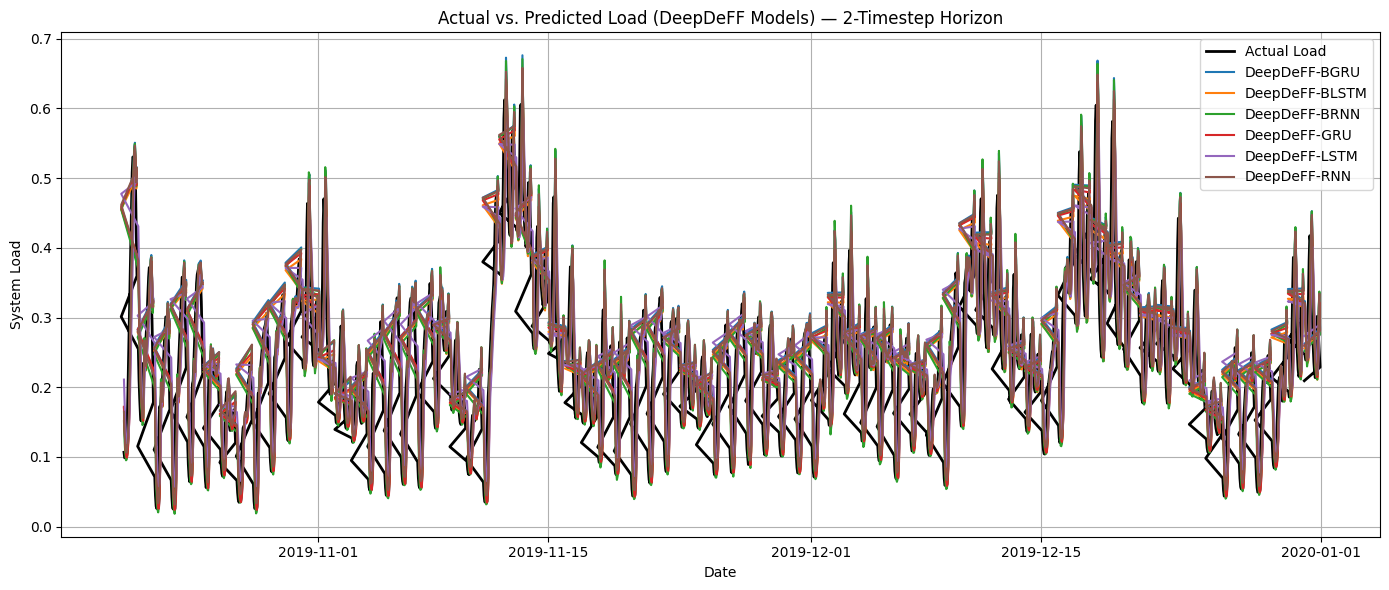

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Adjust these if your test target values were scaled
# (Assuming y_test is still in scaled format and you used MinMaxScaler)
# Inverse transform if needed
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Adjust test_dates if needed
sequence_dates = df.index[timesteps:]  # Offset due to sequence creation
test_dates = sequence_dates[int(0.8 * len(sequence_dates)):]
min_len = min(len(test_dates), len(y_test_original))

# Trim to match lengths
test_dates = test_dates[:min_len]
y_test_original = y_test_original[:min_len]

# Initialize DataFrame with actual load
plot_df = pd.DataFrame({'Actual Load': y_test_original}, index=test_dates)

# Add DeepDeFF predictions
for model_name, preds in predictions_dict_all['DeepDeFF'].items():
    preds = preds[:min_len]
    preds_original = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    plot_df[model_name] = preds_original

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df['Actual Load'], label='Actual Load', linewidth=2, color='black')

for model_name in predictions_dict_all['DeepDeFF'].keys():
    plt.plot(plot_df.index, plot_df[model_name], label=model_name)

plt.title("Actual vs. Predicted Load (DeepDeFF Models) — 2-Timestep Horizon")
plt.xlabel("Date")
plt.ylabel("System Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
traditional_models = ['GRU', 'LSTM', 'RNN']
deepdeff_models = ['GRU', 'LSTM', 'RNN', 'BGRU', 'BLSTM', 'BRNN']  # or whatever is in your deepdeff_results

print("\nResults achieved on dataset (MAPE %, RMSE, R²):\n")

print("Traditional Models:")
print("Method\t\tTimestep\tMAPE (%)\tRMSE\t\tR²")

for model in traditional_models:
    for t in timesteps_list:
        if model in final_results[t]:
            mape = final_results[t][model]['MAPE (%)']
            rmse = final_results[t][model]['RMSE']
            r2 = final_results[t][model]['R²']
            print(f"{model:<12}\t{t:<9}\t{mape:<10.2f}\t{rmse:<10.4f}\t{r2:<.4f}")
    print()

print("\nDeepDeFF Models:")
print("Method\t\tTimestep\tMAPE (%)\tRMSE\t\tR²")

for model in deepdeff_models:
    for t in timesteps_list:
        if model in deepdeff_results[t]:
            mape = deepdeff_results[t][model]['MAPE (%)']
            rmse = deepdeff_results[t][model]['RMSE']
            r2 = deepdeff_results[t][model]['R²']
            print(f"DeepDeFF-{model:<6}\t{t:<9}\t{mape:<10.2f}\t{rmse:<10.4f}\t{r2:<.4f}")
    print()




Results achieved on dataset (MAPE %, RMSE, R²):

Traditional Models:
Method		Timestep	MAPE (%)	RMSE		R²
GRU         	2        	8.80      	0.0217    	0.9553
GRU         	6        	6.70      	0.0208    	0.9593
GRU         	12       	8.54      	0.0251    	0.9402

LSTM        	2        	14.89     	0.0334    	0.8947
LSTM        	6        	13.60     	0.0343    	0.8884
LSTM        	12       	9.99      	0.0294    	0.9182

RNN         	2        	5.16      	0.0163    	0.9748
RNN         	6        	8.61      	0.0260    	0.9360
RNN         	12       	8.26      	0.0240    	0.9454


DeepDeFF Models:
Method		Timestep	MAPE (%)	RMSE		R²
DeepDeFF-GRU   	2        	7.36      	0.0191    	0.9654
DeepDeFF-GRU   	6        	7.14      	0.0223    	0.9529
DeepDeFF-GRU   	12       	10.72     	0.0314    	0.9068

DeepDeFF-LSTM  	2        	16.54     	0.0363    	0.8754
DeepDeFF-LSTM  	6        	10.08     	0.0283    	0.9240
DeepDeFF-LSTM  	12       	8.73      	0.0262    	0.9348

DeepDeFF-RNN   	2        	6.80      	0.